In [1]:
import requests
import pathlib

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
import seaborn as sns
import plotly.express as pex
from uk_covid19 import Cov19API

### Download the data from gov.uk

In [2]:
cases_path = pathlib.Path("data", "coronavirus-cases_latest.csv")
death_path = pathlib.Path("data", "coronavirus-deaths_latest.csv")
# Remove existing files
for p in [cases_path, death_path]:
    if p.exists():
        p.unlink()

In [3]:
regions = [
    'areaType=region',
]
cases_and_deaths = {
    "date": "date",
    "areaName": "areaName",
    "areaCode": "areaCode",
    "newCasesBySpecimenDate": "newCasesBySpecimenDate",
    "cumCasesBySpecimenDate": "cumCasesBySpecimenDate",
    "cumCasesBySpecimenDateRate": "cumCasesBySpecimenDateRate",
    "newDeaths28DaysByDeathDate": "newDeaths28DaysByDeathDate",
    "cumDeaths28DaysByDeathDate": "cumDeaths28DaysByDeathDate"
}
api = Cov19API(filters=regions, structure=cases_and_deaths)
data = api.get_csv()
with cases_path.open("wt") as p:
    p.write(data)

### Import and reformat the data

Use a 5-day moving average to make general patterns clearer

In [4]:
covid_data = pd.read_csv(cases_path)
covid_data["date"] = pd.to_datetime(covid_data["date"])

In [5]:
covid_data.head()

,date,areaName,areaCode,newCasesBySpecimenDate,cumCasesBySpecimenDate,cumCasesBySpecimenDateRate,newDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDate
0,2020-12-12,East Midlands,E12000004,78,153445,3173.0,7.0,5086.0
1,2020-12-11,East Midlands,E12000004,859,153367,3171.4,26.0,5079.0
2,2020-12-10,East Midlands,E12000004,1250,152508,3153.6,33.0,5053.0
3,2020-12-09,East Midlands,E12000004,1377,151258,3127.8,37.0,5020.0
4,2020-12-08,East Midlands,E12000004,1390,149881,3099.3,27.0,4983.0


In [6]:
n_days=5

In [7]:
region_data = (covid_data
 .sort_values(by=["date"])
     .set_index(["date"])
 .groupby(["areaName"])
     ["newCasesBySpecimenDate"]
 .rolling(n_days)
 .mean()
 .reset_index()
 .rename(columns={
      "newCasesBySpecimenDate" : f"Daily lab-confirmed cases ({n_days} day average)"
  })
  .merge(covid_data)
)
region_data = region_data[~ pd.isna(region_data[f"Daily lab-confirmed cases ({n_days} day average)"])]

In [8]:
region_deaths = (covid_data
 .sort_values(by=["date"])
     .set_index(["date"])
 .groupby(["areaName"])
     ["newDeaths28DaysByDeathDate"]
 .rolling(n_days)
 .mean()
 .reset_index()
 .rename(columns={
      "newDeaths28DaysByDeathDate" : f"New deaths ({n_days} day average)"
  })
  .merge(covid_data)
)
region_deaths = region_deaths[~ pd.isna(region_deaths[f"New deaths ({n_days} day average)"])]

In [9]:
region_rates = (covid_data
 .rename(columns={
      "cumCasesBySpecimenDateRate" : f"Cumulative lab-confirmed cases per 100k population"
  })
  .merge(covid_data)
)

# Plot cases and deaths over time by region

In [10]:
%matplotlib widget
f, axes = plt.subplots(1, 3)
p = sns.lineplot(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="date", 
             hue="areaName", 
             data=region_data, 
#              sort=False,
                 ax=axes[0])
# Define the date format
date_form = DateFormatter("%m-%d")
axes[0].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

plt.show()
p2 = sns.lineplot(y=f"New deaths ({n_days} day average)",
                  x="date", 
                  hue="areaName", 
                  data=region_deaths, 
#                   sort=False,
                  ax=axes[1])

# Define the date format
date_form = DateFormatter("%m-%d")
axes[1].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))

p = sns.lineplot(y="Cumulative lab-confirmed cases per 100k population",
             x="date", 
             hue="areaName", 
             data=region_rates, 
                 ax=axes[2])
# Define the date format
date_form = DateFormatter("%m-%d")
axes[2].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
axes[2].xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Cumulative vs new cases

We plot on a log-log scale so that the drop off is more apparent

In [11]:
%matplotlib widget
p = sns.lineplot(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="Cumulative lab-confirmed cases", 
             hue="Area name", 
             data=region_data.rename(columns={"cumCasesBySpecimenDate" : "Cumulative lab-confirmed cases", "areaName" : "Area name"}), 
             sort=False)
p.set_yscale("log")
p.set_xscale("log")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Interactive version of the same graph using plotly

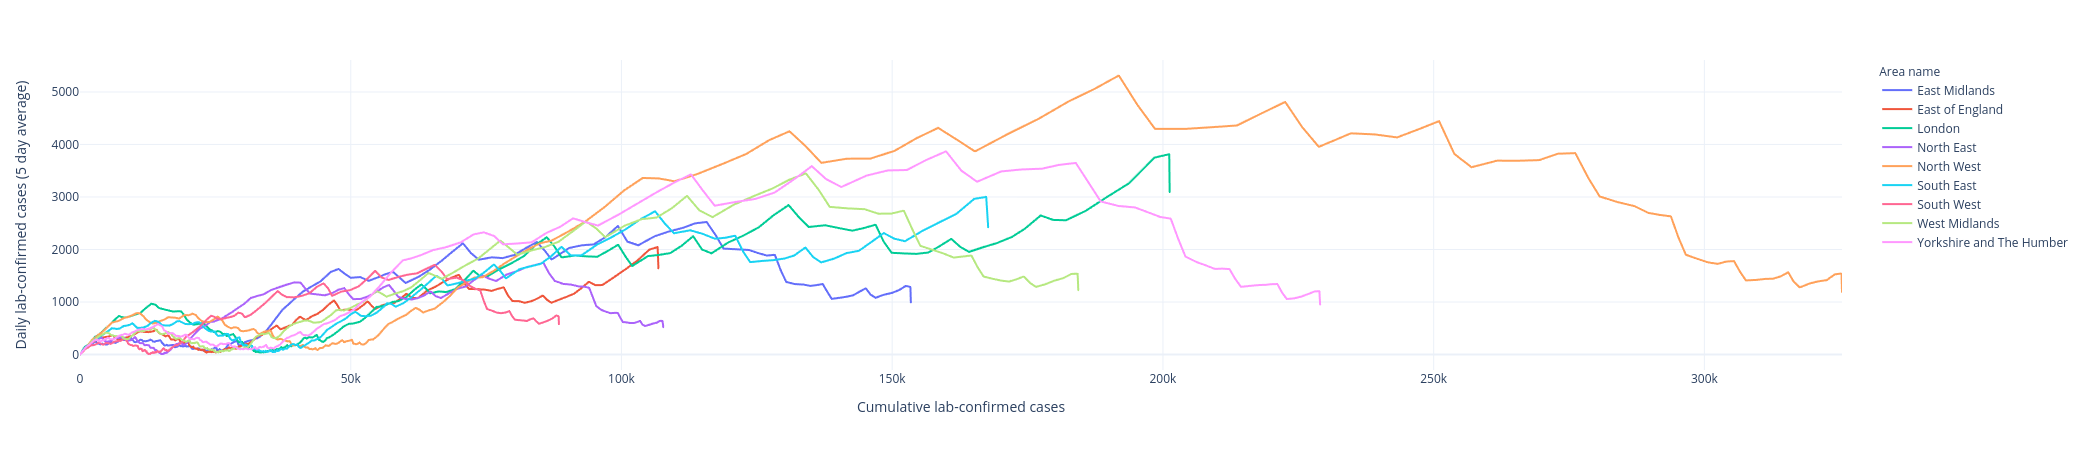

In [13]:
p = pex.line(y=f"Daily lab-confirmed cases ({n_days} day average)",
             x="Cumulative lab-confirmed cases", 
             color="Area name", data_frame=region_data.rename(columns={"cumCasesBySpecimenDate" : "Cumulative lab-confirmed cases", "areaName" : "Area name"}),
            template="plotly_white")
p

# Cumulative vs new deaths

In [14]:
%matplotlib widget
p = sns.lineplot(y=f"New deaths ({n_days} day average)",
             x="Cumulative deaths", 
             hue="Area name", 
             data=region_deaths.rename(columns={"cumDeaths28DaysByDeathDate" : "Cumulative deaths", "areaName" : "Area name"}), 
             sort=False)
p.set_yscale("log")
p.set_xscale("log")


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

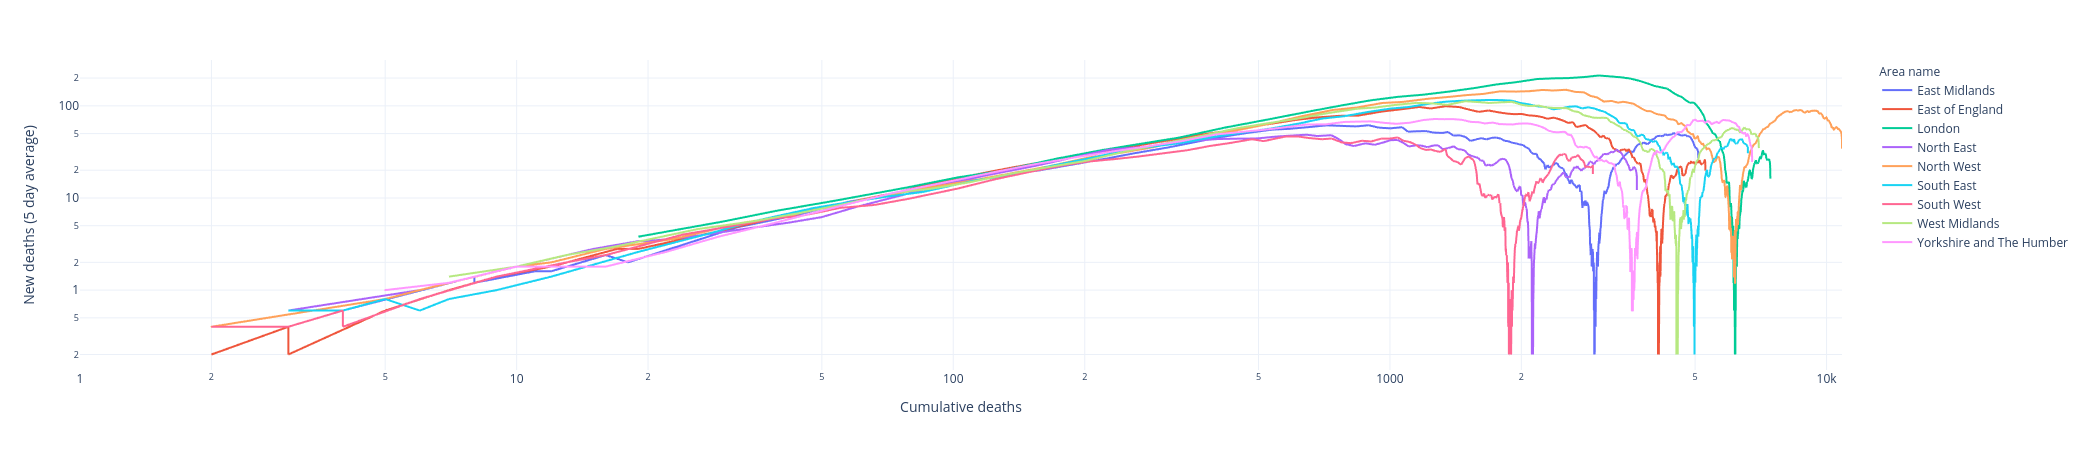

In [15]:
fig = pex.line(y=f"New deaths ({n_days} day average)",
             x="Cumulative deaths", 
             color="Area name", 
             data_frame=region_deaths.rename(columns={"cumDeaths28DaysByDeathDate" : "Cumulative deaths", "areaName" : "Area name"}),
             template="plotly_white")
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig